# "Differentiable Programming of Reaction-Diffusion Patterns" supplementary code

* [Project page](https://selforglive.github.io/alife_rd_textures/)
* [Paper](https://selforglive.github.io/alife_rd_textures/ALIFE_Reaction_Diffusion.pdf)




In [ ]:
#@title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
from scipy import ndimage

from tqdm import tnrange

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_tmp.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_tmp.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


class LoopWriter(VideoWriter):
  def __init__(self, *a, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.fade_len = int(kw.get('fade_len', 1.0)*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.fade_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.fade_len:
      super().add(self._outro.pop(0))

  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()

!nvidia-smi -L

  if event.key is 'enter':



GPU 0: Tesla T4 (UUID: GPU-9f0a6be8-7a70-026c-e59c-ecf24572ca19)


In [ ]:
!wget https://github.com/google-research/self-organising-systems/raw/master/assets/reaction_diffusion_textures/targets.zip && unzip targets.zip

--2025-05-04 19:07:29--  https://github.com/google-research/self-organising-systems/raw/master/assets/reaction_diffusion_textures/targets.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google-research/self-organising-systems/master/assets/reaction_diffusion_textures/targets.zip [following]
--2025-05-04 19:07:29--  https://raw.githubusercontent.com/google-research/self-organising-systems/master/assets/reaction_diffusion_textures/targets.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63479 (62K) [application/zip]
Saving to: ‘targets.zip’

targets.zip         100%[===================>] 

  from scipy.ndimage.filters import gaussian_filter



(1, 96, 96, 32)
Parameter count: 8320
Seed state examples:


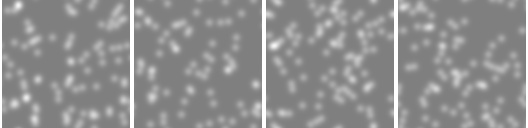

In [ ]:
#@title RD Model definition {vertical-output: true}
from scipy.ndimage.filters import gaussian_filter
from tensorflow.keras.layers import Conv2D

# Number of grid "chemical" channels
CHN = 32
noLaplacian = 0

def seed_f(n, sz=96, spot_prob=0.005, spread=3.0):
  '''Create seed states with scattered gaussian blobs'''
  x = tf.floor(tf.random.uniform([n, sz, sz, 1])+spot_prob)
  x = gaussian_filter(x, [0.0, spread, spread, 0.0], mode='wrap')
  x = x*spread**2
  x = tf.repeat(x, 3, -1)
  x = tf.pad(x, [(0, 0), (0, 0), (0, 0), (0, CHN-x.shape[-1])])
  return x.numpy()

def pad_repeat(x, pad=1):
  x = tf.concat([x[:, -pad:], x, x[:, :pad]], 1)
  x = tf.concat([x[:, :, -pad:], x, x[:, :, :pad]], 2)
  return x

def to_rgb(x):
  return x[...,:3]+0.5

@tf.function
def laplacian(x):
  temp = x[:, :, :, :noLaplacian]
  x = x[:, :, :, noLaplacian:]
  lap = np.float32([[ 1, 2, 1], [2, 4-16, 2], [1, 2, 1]]) / 16.0
  kernel = tf.repeat(lap[:,:,None,None], x.shape[-1], 2)
  x = pad_repeat(x, 1)
  y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'VALID')
  y = tf.concat([temp, y], -1)
  return y

@tf.function
def hamiltonian(x):
  lap = np.float32([[ 1, 2, 1], [2, 4-16, 2], [1, 2, 1]]) / 16.0
  kernel = tf.repeat(lap[:,:,None,None], x.shape[-1], 2)
  x = pad_repeat(x, 1)
  y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'VALID')
  return y


class CA(tf.keras.layers.Layer):
  def __init__(self):
    super(CA, self).__init__() # 親クラスの __init__ を呼び出す
    self.w1 = Conv2D(128, 1)
    self.w2 = Conv2D(CHN, 1, use_bias=False, kernel_initializer=tf.zeros)
    self.diff_coef = tf.repeat([0.125, 0.25, 0.5, 1.0], CHN//4)
    self(seed_f(1))

  def get_giff_coef(self):
    return self.diff_coef

  @tf.function
  def __call__(self, x, r=1.0, d=1.0):
    diff = laplacian(x)*self.get_giff_coef()
    y = self.w1(x)
    y = y*tf.nn.sigmoid(y*5.0)
    react = self.w2(y)
    x = x + diff*d + react*r
    return x

ca = CA()

# Layer は最初に入力形状を知る必要がある (ビルドのため)
# ダミーデータで一度呼び出すことでビルドされる
dummy_seed = seed_f(1) # TensorFlow Tensor を渡す
print(dummy_seed.shape)
_ = ca(dummy_seed) # これで内部の Conv2D レイヤーがビルドされ、重みが作成される

param_n = np.sum([np.prod(v.shape) for v in ca.trainable_variables])
print('Parameter count:', param_n)

print('Seed state examples:')
img = to_rgb(seed_f(4, 128))
img = np.pad(img, [(0, 0), (0, 0), (2, 2), (0, 0)], constant_values=1.0)
imshow(np.hstack(img))

# RD model training

In [ ]:
#@title VGG16 texture model
STYLE_LAYERS = ['block%d_conv1'%i for i in range(1, 6)]
CONTENT_LAYER = 'block4_conv2'

class StyleModel:
  def __init__(self):
    vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
    vgg.trainable = False
    layers = STYLE_LAYERS + [CONTENT_LAYER]
    layers = {name:vgg.get_layer(name).output for name in layers}
    self.model = tf.keras.Model([vgg.input], layers)

  #@tf.function(experimental_relax_shapes=True)
  def run_model(self, img):
    img = img[..., ::-1]*255.0 - np.float32([103.939, 116.779, 123.68])
    layers = self.model(img)
    style = [layers[name] for name in STYLE_LAYERS]
    return style, layers[CONTENT_LAYER]

  def calc_style_content(self, img):
    style_layers, content = self.run_model(img)
    style = [gram_style(a) for a in style_layers]
    return style, content

def gram_style(a):
  n, h, w, ch = tf.unstack(tf.shape(a))
  a = tf.sqrt(a+1.0)-1.0
  gram = tf.einsum('bhwc, bhwd -> bcd', a, a)
  return gram / tf.cast(h*w, tf.float32)

@tf.function
def style_loss(a, b): # reduce_mean
  return tf.add_n([tf.reduce_mean(tf.square(x-y), [-2, -1]) for x, y in zip(a, b)])


style_model = StyleModel()


In [ ]:
#@title Inception model

inception_pb = 'gs://modelzoo/vision/other_models/InceptionV1.pb'

class Inception:
  def __init__(self):
    with tf.io.gfile.GFile(inception_pb, 'rb') as f:
      self.graph_def = tf.compat.v1.GraphDef.FromString(f.read())
    avgpool0_idx = [n.name for n in self.graph_def.node].index('avgpool0')
    del self.graph_def.node[avgpool0_idx:]
    del self.graph_def.node[0]  # placeholder
    # use pre_relu layers for Concat nodes
    self.outputs = []
    for node in self.graph_def.node:
      if 'Concat' in node.op:
        self.outputs.append(node.name+':0')
        self.outputs += [inp+'_pre_relu:0' for inp in node.input[1:]]

  @tf.function(experimental_compile=True)
  def __call__(self, x):
    imgs = x*255.0-117.0
    outputs = tf.import_graph_def(self.graph_def, {'input':imgs}, self.outputs)
    outputs = dict(zip(self.outputs, outputs))
    layers = {}
    for node in self.graph_def.node:
      if 'Concat' in node.op:
        layers[node.name] = outputs[node.name+':0']
        pre_relus = [outputs[inp+'_pre_relu:0'] for inp in node.input[1:]]
        layers[node.name+'_pre_relu'] = tf.concat(pre_relus, -1)
    return layers

model = Inception()
model_name = 'inception'

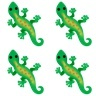

Expected: ['keras_tensor_19']
Received: inputs=Tensor(shape=(1, 96, 96, 3))
  warnings.warn(msg)



In [ ]:
model_name = 'lizard'
style_img = imread('%s_target.jpg'%model_name)
imshow(style_img)

# RD system is fully isotropic, so we use a variant of texture loss that
# tries to match input image with rotated versions of the target sample
target_styles = []
for r in np.linspace(0.0, 360, 65)[:-1]+0.12345:
  img = ndimage.rotate(style_img, r, reshape=False, mode='wrap')
  style, _ = style_model.calc_style_content(img[None,...])
  target_styles.append(style)
imwrite('%s.jpg'%model_name, style_img)

In [ ]:
#@title Setup training
ca = CA()
dummy_seed = seed_f(1) # TensorFlow Tensor を渡す
_ = ca(dummy_seed) # これで内部の Conv2D レイヤーがビルドされ、重みが作成される

loss_log = []

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 10000], [1e-3, 2e-4, 5e-5])
trainer = tf.optimizers.Adam(lr)

@tf.function
def style_loss_f(x):
  imgs = to_rgb(x)
  gs, content = style_model.calc_style_content(imgs)
  sl = np.inf
  for ts in target_styles:
    sl = tf.minimum(sl, style_loss(gs, ts))
  return tf.reduce_mean(sl)

# *BONUS* Inception-V1 feature visualisztion loss may produce
# interesting patterns for some channels (esp. for those
# that correspond to isotropic textures)
@tf.function
def inception_loss_f(x):
  imgs = to_rgb(x)
  clip_imgs = tf.clip_by_value(imgs, 0.0, 1.0)
  overflow_loss = tf.reduce_mean(tf.square(clip_imgs-imgs))
  tensor = model(clip_imgs)['mixed4a_pre_relu']
  loss = -tf.reduce_mean(tensor[...,461])
  return loss + overflow_loss*10.0

pool = seed_f(1024)

@tf.function
def train_step(x):
  with tf.GradientTape() as g:
    step_n = tf.random.uniform([], 32, 128, tf.int32)
    for i in tf.range(step_n):
      x = ca(x)
    loss = style_loss_f(x)
    print(loss)
  params = ca.trainable_variables
  grads = g.gradient(loss, params)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, params))
  return loss, x

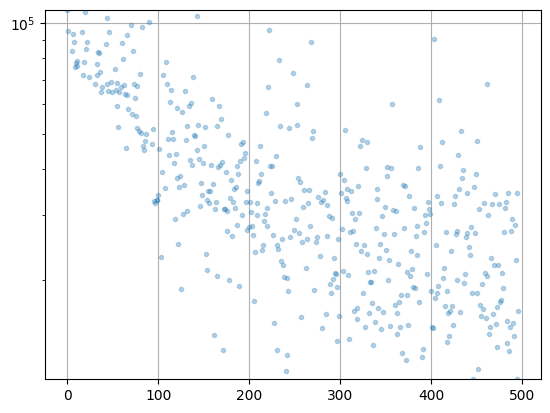

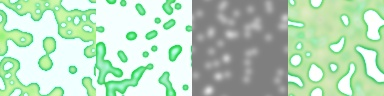

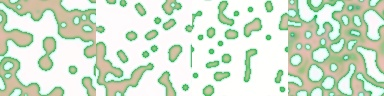

 497 16474.36

KeyboardInterrupt: 

In [ ]:
#@title Training loop {vertical-output: true}
for i in range(20000):
  batch_idx = np.random.choice(len(pool), 4, replace=False)
  x0 = pool[batch_idx]
  if i%32==0:   # periodically inject seed states in the batch
    x0[:1] = seed_f(1)
  h, w = x0.shape[1:-1]
  loss, x = train_step(x0)
  pool[batch_idx] = x
  loss_log.append(loss.numpy())
  if i%16 == 0:
    clear_output(True)
    pl.plot(loss_log, '.', alpha=0.3)
    if np.min(loss_log) > 0.0:
      pl.yscale('log')
    pl.ylim(np.min(loss_log), loss_log[0])
    pl.grid()
    pl.show()
    imshow(np.hstack(to_rgb(x0)))
    imshow(np.hstack(to_rgb(x)))
    print('\r', len(loss_log), loss.numpy(), end='')
  if len(loss_log)%1000 == 0:
    np.save('%s_%05d.npy'%(model_name, len(loss_log)),
            [v.numpy() for v in ca.variables])




In [ ]:
#@title Model behavior video {vertical-output: true}
with VideoWriter() as vid:
  x = seed_f(1, 256)
  for i in tqdm.tnrange(30*8):
    step_n = min(int(2**(i/30.0)), 200)
    for _ in range(step_n):
      x = ca(x, r=0.5)
    frame = to_rgb(x)[0]
    vid.add(zoom(frame, 2))


# Experiments with pretrained models

In [ ]:
!wget https://github.com/google-research/self-organising-systems/raw/master/assets/reaction_diffusion_textures/rd_tex_models.zip

In [ ]:
models = np.load('rd_tex_models.zip', allow_pickle=True)
names = ['banded_0037_20000', 'lined_0118_15000', 'polka-dotted_0121_20000',
         'grid_0135_20000', 'interlaced_0172_20000', 'chequered_0121_20000',
         'lizard_20000']

In [ ]:
#@title Figure 2 {vertical-output: true}
#@markdown RD-generated patterns (videos are stored as "\<model_name\>.mp4")
ca = CA()
rows = []
for name in names:
  src = name.rsplit('_', 1)[0]+'_target.jpg'
  src = imread(src)
  ph, pw = (128-np.int32(src.shape[:2]))//2
  src = np.pad(src, [(ph, ph), (pw, pw), (0, 0)], 'edge')
  [v.assign(p) for p, v in zip(models[name], ca.variables)]
  x = seed_f(3, 128)
  with VideoWriter(name+'.mp4') as vid:
    for i in tnrange(30*10):
      step_n = min(2**(i//30), 128)
      for i in range(step_n):
        x = ca(x)
      img = to_rgb(x)
      img = np.pad(img, [(0, 0), (0, 0), (8, 0), (0, 0)], constant_values=1.0)
      img = np.hstack(img)
      img = np.hstack([src, np.ones([128, 8, 3]), img])
      vid.add(zoom(img, 2))
  imshow(img)
  print(name[:-6])

In [ ]:
#@title Figure 3: grid states at steps 50, 1e2, 1e3, 1e4 {vertical-output: true}
ca = CA()
rows = []
for name in 'lined_0118_15000 polka-dotted_0121_20000 lizard_20000'.split():
  [v.assign(p) for p, v in zip(models[name], ca.variables)]
  x = seed_f(1, 128)
  imgs = []
  for i in range(10000):
    x = ca(x)
    if (i+1) in [50, 100, 1000, 10000]:
      img = to_rgb(x)[0]
      img = np.pad(img, [(2, 2), (2, 2), (0, 0)], constant_values=1.0)
      imgs.append(img)
  row = np.hstack(imgs)
  rows.append(row)
  imshow(row)
imwrite('rows.jpg', np.vstack(rows))

In [ ]:
#@title Figure 4: non-unifirm diffusion speed {vertical-output: true}
y, x = np.ogrid[-2:2:256j,-2:2:256j]
s = 3**-2
r = s+np.exp(-x*x-y*y)*(1.0-s)
r = np.float32(r[:,:,None])

ca = CA()
for name in names:
  [v.assign(p) for p, v in zip(models[name], ca.variables)]
  x = seed_f(1, 256)
  for i in tnrange(10000, leave=False):
    x = ca(x, r=r)
  imshow(to_rgb(x)[0])

In [ ]:
#@title Figure 4 (non-unifirm diffusion speed video) {vertical-output: true}
y, x = np.ogrid[-2:2:256j,-2:2:256j]
s = 3**-2
r = s+np.exp(-x*x-y*y)*(1.0-s)
r = np.float32(r[:,:,None])

ca = CA()
[v.assign(p) for p, v in zip(models['grid_0135_20000'], ca.variables)]

with LoopWriter('loop.mp4') as vid:
  x = seed_f(1, 256)
  for i in tnrange(30*10, leave=False):
    step_n = min(int(2**(i/30.0)), 200)
    for _ in range(step_n):
      x = ca(x, r=r)
    img = tf.image.resize(to_rgb(x)[0], [512, 512], tf.image.ResizeMethod.BICUBIC)
    vid.add(img)
vid.show(loop=True)

# Mesh and Volume generalization

In [ ]:
!pip install trimesh vispy
import vispy
vispy.use(app='egl')

In [ ]:
!wget http://graphics.stanford.edu/pub/3Dscanrep/bunny.tar.gz && tar -xzf bunny.tar.gz

In [ ]:
import trimesh
mesh = trimesh.load('bunny/reconstruction/bun_zipper.ply')
mesh.vertices -= mesh.vertices.mean(0, keepdims=True)
mesh.vertices /= mesh.vertices.ptp()
lap = trimesh.smoothing.laplacian_calculation(mesh, False)
lap = tf.sparse.SparseTensor(np.c_[lap.row, lap.col],
                           np.float32(lap.data), lap.shape)

In [ ]:
#@title mesh 3d render
from vispy import gloo, app

vertex = """
    uniform float aspect;
    uniform mat4 T;
    attribute vec3 position;
    attribute vec3 normal;
    attribute vec3 color;
    varying vec3 v_color;
    varying vec3 v_normal;
    void main()
    {
      v_color = color;
      v_normal = (T*vec4(normal, 1.0)).rgb;
      vec4 p = T*vec4(position, 1.0);
      float zoom = 1.4;
      gl_Position = vec4(zoom*p.x,
                         zoom*p.y*aspect,
                         -p.z, 1.0-p.z*0.2);
    } """

fragment = """
    varying vec3 v_color;
    varying vec3 v_normal;
    void main() {
      vec3 n = normalize(v_normal);
      gl_FragColor = vec4(v_color*n.z, 1.0);
    } """

class Canvas(app.Canvas):
    def __init__(self, mesh):
        super().__init__(size=(800, 600))

        self.indices = gloo.IndexBuffer(np.uint32(mesh.faces))
        self.program = gloo.Program(vertex, fragment)
        self.program['position'] = np.float32(mesh.vertices.copy())
        self.program['normal'] = np.float32(mesh.vertex_normals.copy())
        w, h = self.size
        self.program['aspect'] = w/h

    def on_draw(self, event):
      gloo.set_state('opaque')
      gloo.set_clear_color('white')
      gloo.clear()
      self.program.draw('triangles', self.indices)

    def render_mesh(self, color, T=np.eye(4)):
      self.program['color'] = color
      self.program['T'] = T
      return self.render()[..., :3]

renderer = Canvas(mesh)

In [ ]:
names

In [ ]:
#@title Figure 5: RD model on a mesh {vertical-output: true}
ca = CA()
name = 'lizard_20000'
[v.assign(p) for p, v in zip(models[name], ca.variables)]

@tf.function
def step_f(ca, x, r=0.8, d=0.5):
  w1 = ca.w1.kernel[0, 0]
  b1 = ca.w1.bias
  w2 = ca.w2.kernel[0, 0]
  lx = tf.sparse.sparse_dense_matmul(lap, x)-x
  diff = lx*ca.get_giff_coef()
  y = x@w1+b1
  y = y*tf.nn.sigmoid(y*5.0)
  react = y@w2
  x = x + diff*d + react*r
  return x

x = np.floor(np.random.rand(len(mesh.vertices), 1)+0.005).astype(np.float32)
for i in range(8):
  x = tf.sparse.sparse_dense_matmul(lap, x)
x *= 6.0
x = np.float32(x*(np.arange(CHN)<3))

fps = 60.0
dur = 10
with VideoWriter('mesh_%s.mp4'%name, fps=fps) as vid:
  for i in tnrange(int(fps*dur)):
    step_n = int(min(2**(i/fps), 30))
    for _ in range(step_n):
      x = step_f(ca, x)
    rgb = to_rgb(x).numpy()
    t = i/(fps*dur)
    t = t*t*(3.0-2.0*t)
    T = trimesh.transformations.rotation_matrix(2*np.pi*t, [0.0, 0.8, 0.2])
    img = renderer.render_mesh(rgb, T)
    vid.add(img)
imwrite('mesh_%s.jpg'%name, img)
vid.show()

In [ ]:
#@title volume renderer code
import vispy.geometry
from vispy import gloo, app

vertex = """
    #version 130
    uniform float aspect;
    uniform float head;
    uniform float pitch;
    in vec3 position;
    out vec3 ray_start;
    out vec3 ray_dir;

    mat2 rot(float a) {
      float c=cos(a), s=sin(a);
      return mat2(c, -s, s, c);
    }
    vec3 tform(vec3 p) {
      p.yz = rot(-pitch)*p.yz;
      p.xz = rot(-head)*p.xz;
      return p;
    }
    void main() {
      ray_start = tform(vec3(0.0, 0.0, -1.8))+0.5;
      ray_dir = tform(vec3(position.xy*vec2(aspect, 1.0), 1.0));
      gl_Position = vec4(position*2.0, 1.0);
    } """

fragment = """
    #version 130
    uniform sampler3D vol;
    uniform vec3 sliceMin;
    uniform vec3 sliceMax;
    in vec3 ray_start;
    in vec3 ray_dir;
    const float dt = 0.005;

    vec2 intersect_box(vec3 orig, vec3 dir) {
      vec3 inv_dir = 1.0 / dir;
      vec3 tmin_tmp = (sliceMin - orig) * inv_dir;
      vec3 tmax_tmp = (sliceMax - orig) * inv_dir;
      vec3 tmin = min(tmin_tmp, tmax_tmp);
      vec3 tmax = max(tmin_tmp, tmax_tmp);
      float t0 = max(tmin.x, max(tmin.y, tmin.z));
      float t1 = min(tmax.x, min(tmax.y, tmax.z));
      return vec2(t0, t1);
    }

    void main() {
      vec3 p = ray_start;
      vec3 d = normalize(ray_dir);
      vec2 t_hit = intersect_box(p, d);
      if (t_hit.x > t_hit.y) {
        discard;
      }
      t_hit.x = max(t_hit.x, 0.0);
      vec4 acc = vec4(0.0);
      for (float t=t_hit.x; t<t_hit.y; t+=dt) {
        vec3 c = texture(vol, p+d*t).rgb;
        float a = 1.0-c.r*c.g*c.b;
        a = a*a;
        c *= a;
        float opacity = 70.0;
        acc.rgb += opacity*dt*c*(1.0-acc.a);
        acc.a += opacity*dt*a*(1.0-acc.a);
        if (acc.a >= 0.95) {
          break;
        }
      }
      gl_FragColor = acc;
    } """

class VolCanvas(app.Canvas):
    def __init__(self, vol):
        super().__init__(size=(600, 600))

        self.vol = gloo.Texture3D(vol,
          interpolation='linear', wrapping='repeat')

        verts, indices, _ = vispy.geometry.create_plane()
        self.indices = gloo.IndexBuffer(indices)
        self.program = gloo.Program(vertex, fragment)
        w, h = self.size
        self.program['aspect'] = w/h
        self.program['position'] = verts
        self.program['vol'] = self.vol
        self.program['sliceMin'] = [0.0, 0.0, 0.0]
        self.program['sliceMax'] = [1.0, 1.0, 1.0]

    def on_draw(self, event):
      gloo.set_state('translucent')
      gloo.set_clear_color('white')
      gloo.clear()
      self.program.draw('triangles', self.indices)

    def render_volume(self, head=0.5, pitch=0.5):
      self.program['head'] = head
      self.program['pitch'] = pitch
      return canvas.render()[...,:3]

In [ ]:
names

In [ ]:
#@title Figure 6: RD model in 3D volume {vertical-output: true}

ca = CA()
name = 'lizard_20000'
[v.assign(p) for p, v in zip(models[name], ca.variables)]

def pad_repeat3d(x, pad=1):
  x = tf.concat([x[:, -pad:], x, x[:, :pad]], 1)
  x = tf.concat([x[:, :, -pad:], x, x[:, :, :pad]], 2)
  x = tf.concat([x[:, :, :, -pad:], x, x[:, :, :, :pad]], 3)
  return x

@tf.function
def step_f(ca, x, r=0.8, d=0.6):
  w1 = ca.w1.kernel[0, 0]
  b1 = ca.w1.bias
  w2 = ca.w2.kernel[0, 0]
  lx = tf.nn.avg_pool3d(pad_repeat3d(x), 3, 1, 'VALID')-x
  diff = lx*ca.get_giff_coef()
  y = x@w1+b1
  y = y*tf.nn.sigmoid(y*5.0)
  react = y@w2
  x = x + diff*d + react*r
  return x

d = 100
x = np.float32(np.floor(np.random.rand(1, d, d, d, 1)+0.001))
for i in range(10):
  x = tf.nn.avg_pool3d(x, 3, 1, 'SAME')
x *= 30.0
x = np.float32(x*(np.arange(CHN)<3))
print(x.max())

canvas = VolCanvas(np.array(to_rgb(x[0])))
imshow(canvas.render_volume())

with VideoWriter('vol_%s.mp4'%name) as vid:
  for i, t in enumerate(tqdm.tqdm_notebook(np.linspace(0.0, 1.0, 400))):
    step_n = int(min(2**(i/30), 50))
    for _ in range(step_n):
      x = step_f(ca, x)
    t = t*t*(3.0-2.0*t)
    canvas.vol.set_data(to_rgb(x[0]).numpy())
    img = canvas.render_volume(head=2.0*np.pi*t+0.3)
    vid.add(img)
    if i%10==0:
      clear_output(True)
      imshow(img)
      print(i, 'steps per frame:', step_n)
  for t in tqdm.tqdm_notebook(np.linspace(0, 2.0*np.pi, 120)):
    t = (np.cos(t)*0.5+0.5)*0.99+0.01
    canvas.program['sliceMin'] = [0.0, 0.0, 1.0-t]
    vid.add(canvas.render_volume(head=0.3))
  clear_output(True)
imwrite('vol_%s.jpg'%name, canvas.render_volume(head=0.3))
vid.show()